# Molecular Dynamics Simulations

## Overview

### Questions

* What is a rigid body? 
* What properties do I need to input to simulate correct dynamics?

### Objectives

* Define a rigid body
* Define the inertia tensor
* Define the diagonalization of the inertia tensor
* Give an example of taking rigid body and orienting it so the tensor is diagonalized


## Boilerplate code

In [4]:
import itertools
import math

import gsd.hoomd
import hoomd
import numpy
import rowan

from hoomd.md import constrain

The `render_rigid_body` function in the next (hidden) cell will render the system state using **fresnel**.

<div class="alert alert-info">
    This is not intended as a full tutorial on <b>fresnel</b> - see the <a href="https://fresnel.readthedocs.io/">fresnel user documentation</a> if you would like to learn more.
</div>

In [7]:
import fresnel
import IPython

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render_rigid_body(pos_body, radius_constituent):
    '''
    outputs the sphere positions in the rigid body depending on the radius of the constituent particles
    '''
    L = 3 * numpy.max(numpy.linalg.norm(pos_body, axis=1))
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(scene,
                                       N=len(pos_body),
                                       radius=radius_constituent)
    geometry.material = fresnel.material.Material(color=fresnel.color.linear(
        [252 / 255, 209 / 255, 1 / 255]),
                                                  roughness=0.5)
    geometry.position[:] = pos_body
    geometry.outline_width = 0.04
    box = fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=.02)
    
    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1),
                            color=(0.8, 0.8, 0.8),
                            theta=math.pi),
        fresnel.light.Light(direction=(1, 1, 1),
                            color=(1.1, 1.1, 1.1),
                            theta=math.pi / 3)
    ]
    scene.camera = fresnel.camera.orthographic(position=(L * 2, L, L * 2),
                                               look_at=(0, 0, 0),
                                               up=(0, 1, 0),
                                               height=L * 1.4 + 1)
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

# Definition of a Rigid Body

A **rigid body** is a rigid object that does not deform or one where deformation can be considered neglibible. 

In hoomd, a rigid body is typically composed of individual particles where the sum of forces on the particles that compose the rigid body are used to integrate that body through the simulation. 

The **body** particle is the center of mass of the rigid body in hoomd, seperately defined are the **constituent** particles that make up the body and are defined separately. 

# Defining a rigid body in hoomd: 

We want to have a rigid body that is defined by two spheres grafted end to end. 

The radius of each sphere is 1, and the position of each sphere in the rigid body is [-1, 0, 0] and [1, 0, 0]. 

We then assume each sphere has a mass of 1 for this example. If we want hoomd to correctly integrate through the moments of inertia for this object, we must correctly define the moments of inertia because this will allow us to integrate over the orientational degrees of freedom for each particle. 

If moments of inertia are not defined, hoomd will simply not integrate over them. 

The moment of inertial tensor for a sphere of mass M and radius R, centered at [0,0,0] is: https://scienceworld.wolfram.com/physics/MomentofInertiaSphere.html
\begin{bmatrix}
2/5 M R^2&0&0\\
0& 2/5 M R^2& 0\\
0&0&2/5 M R^2
\end{bmatrix}

If you displace the sphere by some vector D, the new moment of intertia is: https://en.wikipedia.org/wiki/Moment_of_inertia#Inertia_tensor_of_translation (for further reading). $E_3$ is the identity matrix.

\begin{equation}
I = I_0 + M [(D \cdot D)E_3 + D \otimes D]
\end{equation}

Note that if we also rotated the body we would also have to include a rotation to the inertia tensor. 

We then make a rigid body by summing the two inertia tensors for the spheres. 

Hoomd only takes the 3 principal moments of inertia so it is neccessary to diagonalize the moment of inertia tensor to get the 3 principal moment and then rotate the body so that they coincide with them. 

To do this diagonalize the inertia tensor for the body and then extract the rotation matrix.


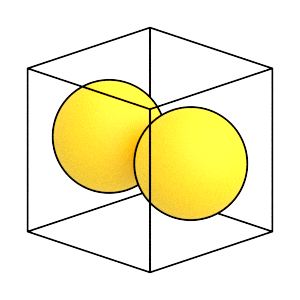

In [8]:
#const_sp_pos1 = numpy.array([.5,.5,0]) 
#const_sp_pos2 = numpy.array([-.5,-.5,0]) 
const_sp_pos1 = numpy.array([-1.,0,0]) 
const_sp_pos2 = numpy.array([1.,0,0]) 
body_pos = numpy.array([const_sp_pos1,const_sp_pos2])
mass = 1
radius = 1

render_rigid_body(body_pos,radius)

Constituent sphere positions for the rigid body

We then calculate the inertia tensor.

If the inertia tensor is diagonalized, there is no need to rotate the object, however if the tensor is not diagonalized, we must proceed using this 3 step procedure. 

### Step 1: Get the Eigenvalues and Eigenvectors of the Inertia Tensor

This is done using a numerical eigenvalue solver, in this case using the numpy linear algebra toolbox.

https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html

The Eigenvalues are the diagonalized principle moments of inertia of the body, while transpose of the eigenvectors is the rotation matrix to rotate the original particles into the frame where the inertia tensor from the frame of reference of the simulation is diagonalized.

Additional information about this procedure is given here. 
https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Graduate_Classical_Mechanics_(Fowler)/24%3A_Motion_of_a_Rigid_Body_-_the_Inertia_Tensor/24.08%3A_Diagonalizing_the_Inertia_Tensor

### Step 2: Transpose the Eigenvectors to get the rotation matrix

### Step 3: Rotate the particles in the rigid body

Rotating a rigid body by the rotation matrix by taking the dot product between the rotation matrix and the original position vectors of the particles. 

In [11]:
I_ref = numpy.array([[2/5*mass*radius**2,0,0],[0,2/5*mass*radius**2,0],[0,0,2/5*mass*radius**2]])

I_1 = I_ref + mass*(numpy.dot(const_sp_pos1,const_sp_pos1)*numpy.identity(3) + numpy.outer(const_sp_pos1,const_sp_pos1))
I_2 = I_ref + mass*(numpy.dot(const_sp_pos2,const_sp_pos2)*numpy.identity(3) + numpy.outer(const_sp_pos2,const_sp_pos2))

I_tot = I_1 + I_2
print(I_tot)
print(I_1)
print(I_2)
print(I_ref)

[[4.8 0.  0. ]
 [0.  2.8 0. ]
 [0.  0.  2.8]]
[[2.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  1.4]]
[[2.4 0.  0. ]
 [0.  1.4 0. ]
 [0.  0.  1.4]]
[[0.4 0.  0. ]
 [0.  0.4 0. ]
 [0.  0.  0.4]]


In [ ]:
# Step 1
I_prin, E_vec = numpy.linalg.eig(I_tot)
print(I_prin)

This gives your principle moments of inertia.

In [ ]:
# Step 2
R = numpy.transpose(E_vec)

# Step 3
const_sp_pos1_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos1])))[:,0]
const_sp_pos2_new =numpy.dot(R,numpy.transpose(numpy.array([const_sp_pos2])))[:,0]

I_1_new = I_ref + mass*(numpy.dot(const_sp_pos1_new,const_sp_pos1_new)*numpy.identity(3) + numpy.outer(const_sp_pos1_new,const_sp_pos1_new))
I_2_new = I_ref + mass*(numpy.dot(const_sp_pos2_new,const_sp_pos2_new)*numpy.identity(3) + numpy.outer(const_sp_pos2_new,const_sp_pos2_new))

I_tot_new = I_1_new + I_2_new
print('New Inertia Tensor', I_tot_new)
print('Principle Moments', I_prin)

Notice how the new principle moments of inertia are the same as the diagonal components of the inertia tensor. 

We now have all the information to correctly add our rigid body to a hoomd simulation. 

We walso want to render the correctly oriented rigid body in the next cell. 

In [ ]:
render_rigid_body(numpy.array([const_sp_pos1_new,const_sp_pos2_new]),radius)

# Our Next tutorial deals with actually adding a rigid body to the simulation. 